In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import os
%matplotlib inline
data = 'admission.csv'
admissions = pd.read_csv(os.path.relpath("Data\\"+data))
admissions.head()

,admit,gpa,gre
0,0,3.177277,594.102992
1,0,3.412655,631.528607
2,0,2.728097,553.714399
3,0,3.093559,551.089985
4,0,3.141923,537.184894


<H3>Holdout Validation</H3>
<p>The simplest way to evaluate a classifier's effectiveness is to:</p>
<ul>
<li>Randomly split data into training and test set</li>
<li>fitting the model using the training set</li>
<li>making predictions on the test set</li>
</ul>
<p>There's no hard and fast rule for how to split test and training data, for now, we'll use 80/20 for training and testing respectively. To do this we'll:</p>
<ul>
<li>use <a href="http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.permutation.html">numpy.random.permutation</a> to return a list containing index values in random order</li>
<li>return a new DataFrame in that list's order</li>
<li>select the first 80% as the training set</li>
<li>select the last 20% as the test set</li>
</ul>


In [2]:
import numpy as np

# Seed RandomState instance
np.random.seed(8)

# Create list of randomized indices from DataFrame
random_indices = list(np.random.permutation(admissions.index))

# Create new DataFrame indexed in the random order
shuffled_admissions = admissions.loc[random_indices]

# Create training frame
train = shuffled_admissions[:515]

# Create test frame
test = shuffled_admissions[515:]




<h3>Accuracy</h3>
<p>Now that the data is randomized, let's fit a logistic regression and evaluate it</p>

<p>$Accuracy=\frac{\#\:correctly\:predicted}{\#\:of\:Observations}$</p>

In [3]:
lr = LogisticRegression()

# Fit the regression model
lr.fit(train[['gpa']],train['admit'])

# Predict labels and add to test dataframe
test['predicted_label'] = list(lr.predict(test[['gpa']]))

# Calculate accuracy
accuracy = test[test['predicted_label']==test['admit']].shape[0] / test.shape[0]

print(accuracy)


0.6356589147286822


C:\Users\v-haharv\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<H3>Digging into accuracy</H3>
<p>So the prediction accuracy in this model with the holdout set is ~64% which is close to the original estimate using the full set in the Logistic Regressions Basics notebook</p>
<p>If the model performs <em>WAY WORSE</em> on the holdout data, it's a sign that we're overfitting. If the accuracy is much lower, then it may be a sign that the feature we're using isn't great or we should reconsider using logistic regression</p>

<h4>Sensitivity and Specificity (again)</h4>
<p>Sensitivity is the rate at which the model predicts true positives</p>
<p>Specificity is the rate at which the model predicts true negatives</p>

<p>$Sensitivity=\frac{True\:Positives}{True\:Positives+False\:Positives}$</p>

<p>$Specificity=\frac{True\:Negatives}{True\:Negatives+\:False\:Negatives}$</p>

In [4]:
test['actual_label'] = test['admit']

matches = test["predicted_label"] == test["actual_label"]
correct_predictions = test[matches]

true_positive_filter = (test["predicted_label"] == 1) & (test["actual_label"] == 1)
true_positives = len(test[true_positive_filter])
false_negative_filter = (test["predicted_label"] == 0) & (test["actual_label"] == 1)
false_negatives = len(test[false_negative_filter])

sensitivity = true_positives / (true_positives + false_negatives)
print(sensitivity)

false_positive_filter = (test["predicted_label"] == 1) & (test["actual_label"] == 0)
false_positives = len(test[false_positive_filter])
true_negative_filter = (test["predicted_label"] == 0) & (test["actual_label"] == 0)
true_negatives = len(test[true_negative_filter])

specificity = (true_negatives) / (false_positives + true_negatives)
print(specificity)



0.08333333333333333
0.9629629629629629


C:\Users\v-haharv\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<H3>False Positive Rate Deeper Dive</H3>
<p>When we use the LogisticRegression.predict method, scikit-learn uses the logit function, $\sigma(t)=\frac{e^t}{1+e^t}$, to determine the probability value of each observation, then assigns a 1/0 if it's greater than a threshold (50% by default). For most problems, though, 50% is not the optimal $discrimination\:threshold$ so accordingly, we would ideally have a way to compute measures at varied threshold values and optimize our model depending on our objectives.</p>

<p>As stated above, we have two fundamental measures for a given discrimination threshold:</p>
<ol>
<li>False Positive Rate (also known as Fall-out rate)</li>
<li>True Positive Rate</li>
</ol>

<H3>The ROC Curve</H3>
<p>We can vary the discrimination threshold and calculate the TPR and FPR for each threshold. This results in an $ROC\:curve$ which stands for $Receiver\:Operator\:Curve$, which allows us to determine the classification model's performace for all values of the discrimination threshold</p>
<p>For this we use the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">scikit-learn ````roc_curve```` function</a></p>
<p>The roc_curve function takes two requred parameters ````y_true: list of true labels```` and ````y_score: list of probability scores for those observations````</p>
<p>The ````roc_curve```` function returns 3 values that you can assign to separate variables when you call the function ````fpr, tpr, thresholds = metrics.roc_curve(labels, probabilities)````</p>



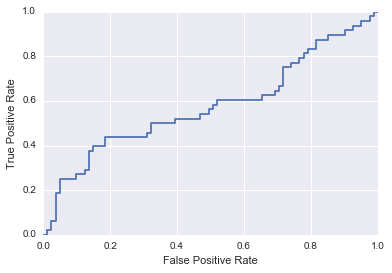

In [19]:
# Import roc_curve
from sklearn.metrics import roc_curve

# Generate probs for model from observations
probs = lr.predict_proba(test[['gpa']])

# use roc_curve to generate fpr, tpr, and thresholds variable
fpr,tpr,thresholds = roc_curve(list(test['actual_label']),probs[:,1])

# Plot ROC
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

<H3>Area Under the Curve</H3>
<p>Looking at the ROC curve above, you can see the tradeoff of increasing the true positive rate--as that increases, so does the false positive rate, since they both converge to 1</p>
<p>Going further, we can calculate the $Area\:under\: the\: curve$ which describes the probability that the classifier will catch a random positive observation higher than a random negative observation</p>
<p>We can use the scikit-learn function <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">````roc_auc_score````</a> which takes the same paramaters as the ````roc_curve```` function</p>

In [14]:
# Import auc_score
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(list(test['actual_label']),probs[:,1])

print(auc_score)
print("our model is slightly better than flipping a coin!!!!")

0.577932098765
our model is slightly better than flipping a coin!!!!
